# Описание проекта

**Задача:**

Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга я подготовил список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируйте результаты.

**План работ:**

1. Загрузить данные и посмотреть на предмет пропусков, дубликатов, типов данных. Сделать небольшой EDA.
2. Рассчитать и приоритизировать гипотезы по фреймворкам ICE и RICE.
3. Анализ АБ-теста
* Рассчитать и построить график кумулятивных показателей и относительного изменения показателей между группами: количества заказов, выручки, ср. чека
* Проверить показатели на предмет выбросов. Если выбросы есть, то сделать "очищенную версию" данных
* Посчитать стат. значимость основных показателей, полученных при эксперименте. По "сырым" и "очищенным" данным.
* Написать выводы и сделать вердикт.

## Загрузка и обзор данных

In [1]:
# Подключим необъодимые библиотеки

import pandas as pd
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# Загрузим данные
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])

print(visitors.shape)
print(orders.shape)
print(hypothesis.shape)

(62, 3)
(1197, 5)
(9, 5)


In [3]:
# Пощупаем данные

print('visitors:')
visitors.info()
print()
print('orders:')
orders.info()

print()
print('hypothesis:')
hypothesis.info()

visitors:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB

orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB

hypothesis:
<class 'pandas.core.frame.DataFram

С виду всё в порядке. Пропусков не видно, типы колонок в норме (тип даты мы исправили ещё и при загрузке датасета).

Единственное - приведём название колонок в нижний регистр.

In [4]:
hypothesis.columns = map(str.lower, hypothesis.columns)
orders.columns = map(str.lower, orders.columns)
visitors.columns = map(str.lower, visitors.columns)

hypothesis.head(10)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Поля таблицы с гипотезами: 
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [5]:
# Посмотрим примеры других таблиц

display(visitors.sample(5))
display(orders.sample(5))

,date,group,visitors
39,2019-08-09,B,610
12,2019-08-13,A,748
32,2019-08-02,B,581
15,2019-08-16,A,361
30,2019-08-31,A,699


,transactionid,visitorid,date,revenue,group
375,1863281703,1959144690,2019-08-25,16480,A
636,3560142722,2531836666,2019-08-09,4990,B
494,1207030791,2700013943,2019-08-26,1980,B
282,3592105335,3279802827,2019-08-18,1990,A
210,1803127824,2830871062,2019-08-02,100,B


In [6]:
# Для удобства переименуем столбцы в заказах
orders.columns = ['orderId', 'userId', 'date', 'revenue', 'group']

Поля для таблицы заказов:
* `orderId` — идентификатор заказа;
* `userId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Поля таблицы посетителей:
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Проверим таблицы на дубликаты:

In [7]:
print("Дубликатов в orders:", len(orders[orders.duplicated(keep=False)]))
print("Дубликатов в visitors:", len(visitors[visitors.duplicated(keep=False)]))

Дубликатов в orders: 0
Дубликатов в visitors: 0


Посмотрим на минимальную и максимальную дату эксперимента, а также количество событий в каждой группе.

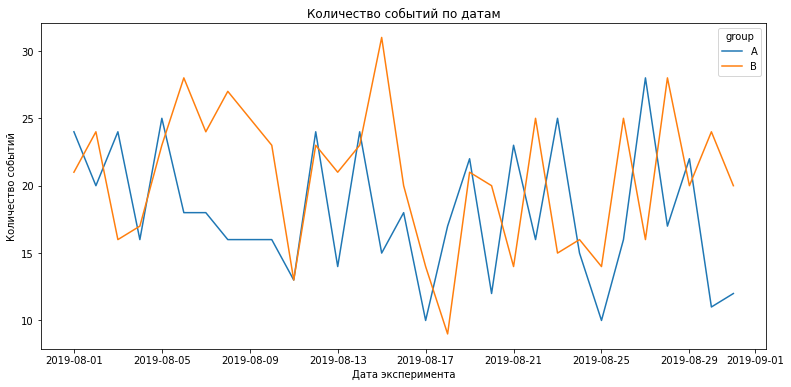

In [8]:
plt.figure(figsize=(13, 6))

# Сгруппируем orders по дате и количестве записей
sns.lineplot(data=orders.groupby(['date','group']).size().reset_index(name='count'), 
             x='date', y='count', hue='group');

plt.xlabel('Дата эксперимента');
plt.ylabel('Количество событий');
plt.title('Количество событий по датам');

Дата от 1 августа 2018 до 1 сентября 2019. Нигде количество записей не падает до нуля.

Также посмотрим - не попадают ли какие пользователи в обе группы эксперимента:

In [9]:
# Группируем по юзеру и группе
user_two_groups = orders.pivot_table(index=['userId', 'group'], values='revenue', aggfunc='count').reset_index().sort_values('group', ascending=False)

# Создаём лист с дублированными id
user_two_list = user_two_groups[user_two_groups['userId'].duplicated()]['userId']

# Выводим общее количество и дублей
print('Количество пользователей в обеих группах одновременно:', len(user_two_list))

print('Общее количество пользователей:', user_two_groups['userId'].count() 
                                         - user_two_groups[user_two_groups['userId'].duplicated()].count()['userId'])

Количество пользователей в обеих группах одновременно: 58
Общее количество пользователей: 1031


Количество дублированных пользователей составляет около 5%. Думаю, что можно их удалить из-за внесение искажений и небольшого процента от общего количества.

In [10]:
# Делаем срез и убираем дублированных пользователей

orders = orders.query('userId not in @user_two_list')
print('Общее количество пользователей после среза: ', len(orders.groupby('userId')['userId']))

Общее количество пользователей после среза:  973


Пользователи успешно срезаны.

**Выводы:**

* Пропусков и несоответствие типов данных не обнаружено
* Для удобства переименовали столбы в таблице orders
* Проверили непрерывность дат, а также мин. и макс.
* Проверили попадание пользователей в обе группы и сделали срез

## Приоритизация гипотез

Проверка гипотез - удовольствие дорогое. Поэтому нужно гипотезы отранжировать по степени важности. Для этого у нас есть фреймворки по отбору гипотез: WSJF, ICE и RICE.

В таблице `hypothesis` - 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

**Задача**
* Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

### ICE

Метод определения приоритетов **ICE** был придуман Шоном Эллисом, который известен авторством термина Growth Hacker.
Первоначально ICE был предназначен для приоритизации экспериментов по росту. Позже ICE стали использовать и для приоритизации фичей.

В ICE оцениваются идеи таким образом:
* **Влияние** демонстрирует, насколько идея положительно повлияет на ключевой показатель, который вы пытаетесь улучшить.
* **Легкость** реализации или простота — это оценка того, сколько усилий и ресурсов требуется для реализации этой идеи.
* **Уверенность** демонстрирует, насколько вы уверены в оценках влияния и легкости реализации.

Значения в ICE оцениваются по шкале от 1 до 10, чтобы все факторы сбалансировано повлияли на итоговое число.

In [11]:
# Начнём приоритизацию с ICE

# Сделаем так, чтобы был виден весь текст в колонках
pd.set_option('display.max_colwidth', None)

hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'], 2)
display(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### RICE

**RICE** — это метод приоритизации идей и фич продукта. Аббревиатура включает 4 фактора, которые менеджер продукта может смело использовать для оценки и приоритизации продуктовых фич:

* **Reach** — это охват
* **Impact** — влияние
* **Confidence** — уверенность в вашей оценке охвата, влияния и трудозатрат
* **Effort** — трудозатраты

Чтобы получить оценку по RICE, вам необходимо объединить эти факторы.

In [12]:
# Теперь второй фреймворк

hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [13]:
# Выводим общую таблицу с двумя гипотезами
display(hypothesis[['hypothesis', 'RICE', 'ICE']].sort_values(['RICE', 'ICE'], ascending=False))

,hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,11.20
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,7.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,13.33
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,8.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,1.12
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,1.33
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,1.00


Для наглядности построим точечный график со сравнением гипотезных метрик:

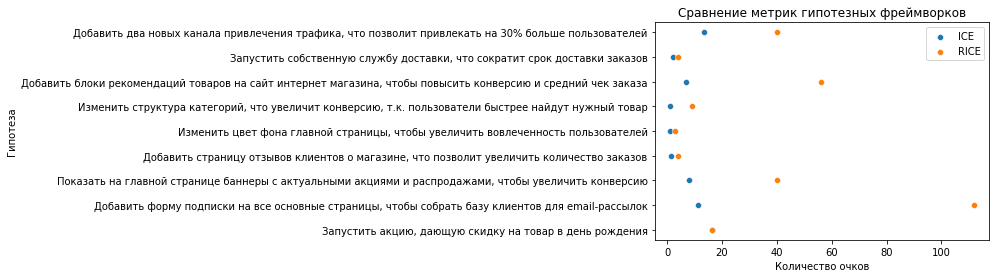

In [14]:
sns.scatterplot(data = hypothesis, x = "ICE", y = "hypothesis", label='ICE').set_title('Сравнение метрик гипотезных фреймворков');
sns.scatterplot(data = hypothesis, x = "RICE", y = "hypothesis", label='RICE');

plt.xlabel('Количество очков');
plt.ylabel('Гипотеза');

На точечном графике наглядно видны различия в метрике охвата (Reach). 

Любопытно, что в одной гипотезу ("Запустить акцию..") - метрики полностью сошлись. В трёх других - метрики стоят очень рядом.

**Выводы:**
* Рейтинг и топ гипотез у фреймворков полностью отличаются. Например, самая приоритетная гипотеза у фреймворков отличается. У ICE - это "Запустить акцию, дающую скидку на товар в день рождения". У RICE - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
* Скорее всего это связано с "R" - охватом, т.к. во фреймворке RICE - первые гипотезы явно направлены на максимальный охват. А, например, в ICE топовая гипотеза направлена на узкий сегмент - у кого ДР.
* В ТОП-3 у фреймворков находится гипотеза "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователе". У этой гипотезы сильный Impact и Confidence.

## Анализ A/B-теста

### График кумулятивной выручки по группам

Чтобы исключить проблему подсматривания, анализируют графики метрик. Изучают графики **кумулятивных**, или накапливаемых данных.

По центральной предельной теореме значение кумулятивных метрик часто сходится и устанавливается около некоторого среднего. Тогда по графику кумулятивных метрик определяют, стоит останавливать тест или нет.

In [15]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Выводим таблицу с кумулятивными данными
display(cumulativeData.head()) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Объявим переменные `cumulativeRevenueA` и `cumulativeRevenueB`, в которых сохраним данные о датах, выручке и числе заказов в группах A и B.
Построим графики кумулятивной выручки по дням по группам.

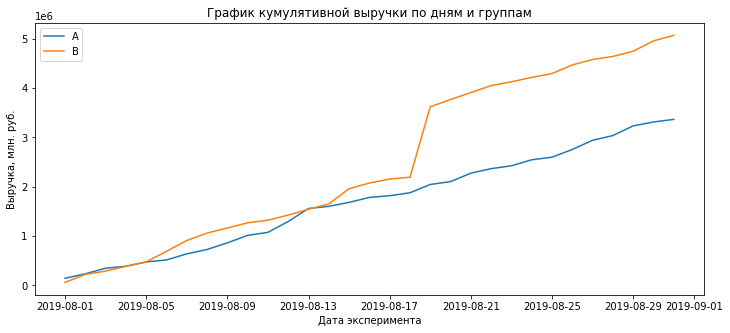

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Определяем размер графика и подпись
plt.figure(figsize=(12, 5))
plt.title("График кумулятивной выручки по дням и группам")

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A');

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B');

plt.xlabel('Дата эксперимента')
plt.ylabel('Выручка, млн. руб.')
plt.legend();

В середине теста группа B сильно вырвалась вперёд и продолжила лидировать весь тест. Что это? Аномально большие заказы?

### График кумулятивного среднего чека по группам

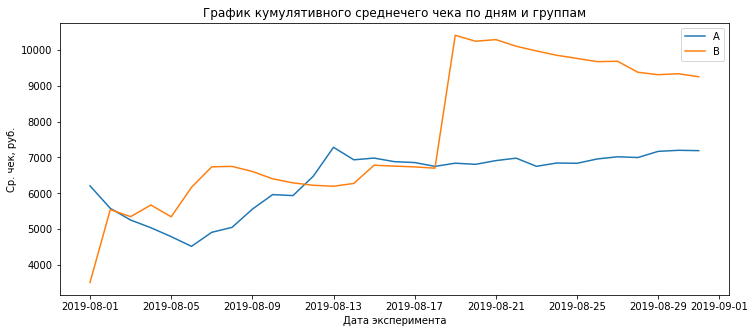

In [17]:
# Определяем размер графика и подпись
plt.figure(figsize=(12, 5))
plt.title("График кумулятивного среднечего чека по дням и группам")

# Средний чек
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A');
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B');

plt.xlabel('Дата эксперимента')
plt.ylabel('Ср. чек, руб.')
plt.legend();

В середине теста у группы B также резко увеличился средний чек. Похоже, что кто-то заказывал товары на большие суммы и из-за этого произошёл всплеск. Причём данные не устаканились даже в конце срока тестов.

Также виден всплеск ср. чека у группы "B" в начале тестов.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

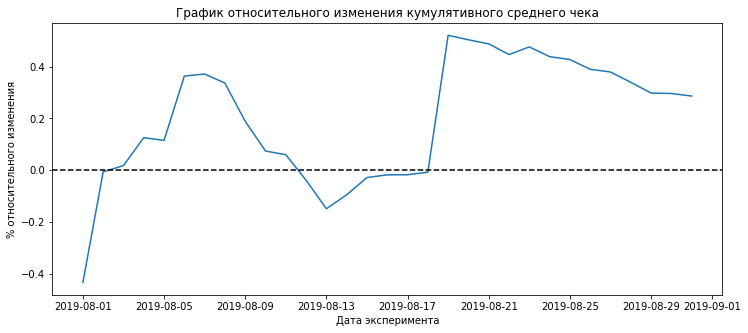

In [18]:
# Определяем размер графика и подпись
plt.figure(figsize=(12, 5))
plt.title("График относительного изменения кумулятивного среднего чека")

# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1);

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

plt.xlabel('Дата эксперимента');
plt.ylabel('% относительного изменения');

Видны резкие изменения в несколких датах. В это время и были совершены аномальные заказы. Посмотрим на эти выбросы чуть позже. 

### Изменения кумулятивной конверсии группы B к группе A

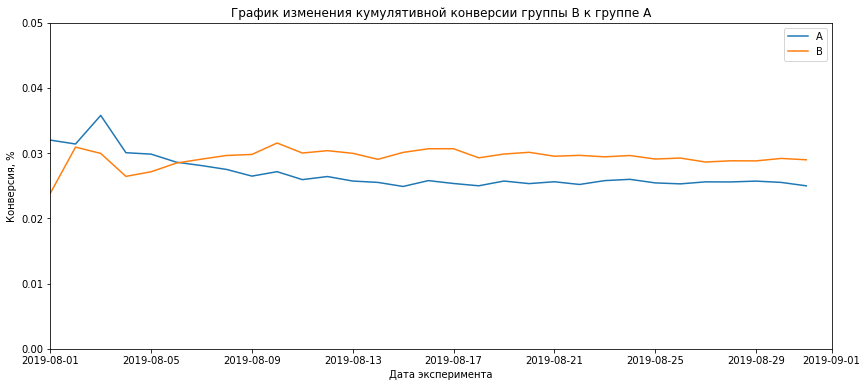

In [19]:
# Определяем размер графика и подпись
plt.figure(figsize=(14, 6))
plt.title("График изменения кумулятивной конверсии группы B к группе A")

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A');
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B');
plt.legend();

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05]);

plt.xlabel('Дата эксперимента');
plt.ylabel('Конверсия, %');

В начальном периоде группа B вырвалась вперёд по конверсии и зафиксировала за собой результат. Разница примерно в половину процента.

Посмотрим на относительные изменения кумулятивной конверсии.

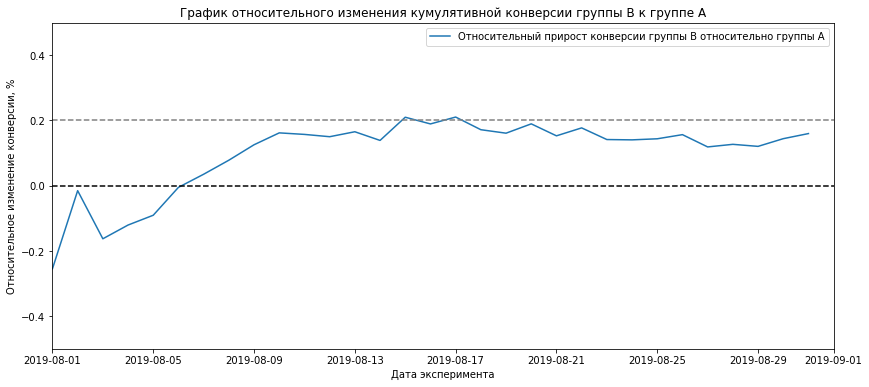

In [20]:
# Определяем размер графика и подпись
plt.figure(figsize=(14, 6))
plt.title("График относительного изменения кумулятивной конверсии группы B к группе A")

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5]);

plt.xlabel('Дата эксперимента');
plt.ylabel('Относительное изменение конверсии, %');

Группа B стабильно была больше в конверсии на протяжении периода, чем A. Изменения были в пределах **10-20%**.

После примерно 21 августа наступила стабилизация показателя.

### Точечный график количества заказов по пользователям

In [21]:
# Отсортируем по убыванию количества заказов пользователей и выведим на экран первые 10 строк

ordersByUsers = (
    orders.groupby('userId', as_index=False)
    .agg({'orderId': 'nunique'})
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 


         userId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


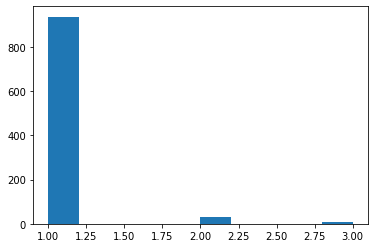

In [22]:
# Теперь перейдём к визуальному анализу
plt.hist(ordersByUsers['orders']);

Большинство пользователей совершили по 1 заказу, но видны столбцы на 2-х и 3-х заказах. Построим точечный график.

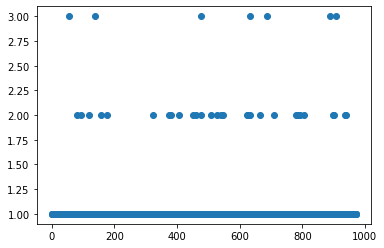

In [23]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']);

Пользователей с более чем двумя заказами немного, но пока нет точных цифр. Посмотрим на конкретные цифры по перцентилям.

Посмотрим 95-й и 99-й перцентили количества заказов на пользователя

In [24]:
orders_95 = int(np.percentile(ordersByUsers['orders'], [95]))
np.percentile(ordersByUsers['orders'], [95], [99])

1

Не более **5%** совершили больше **одного** заказа. И не более **1%** - больше **двух** заказов.

### Точечный график стоимостей заказов


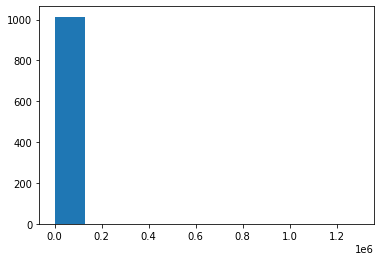

In [25]:
# Сначала глянем на гистограму
plt.hist(orders['revenue']);

Стоимость большинства заказов меньше **200 тысяч** рублей. Конкретные выбросы на этом графике не видны.

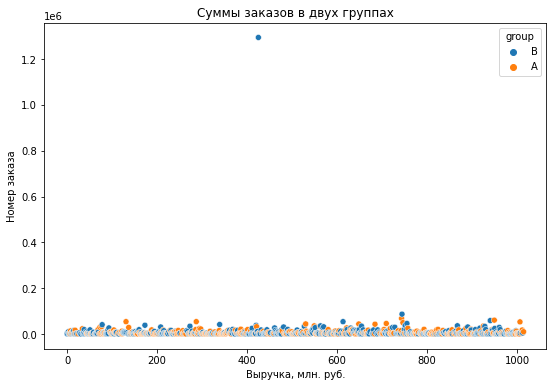

In [26]:
plt.figure(figsize=(9, 6))

x_values = pd.Series(range(0, len(orders['revenue'])))
sns.scatterplot(x=x_values, y=orders['revenue'], hue=orders['group']).set_title('Суммы заказов в двух группах');

plt.xlabel('Выручка, млн. руб.');
plt.ylabel('Номер заказа');

Вот он выброс на заказ больше 1.2 млн руб. в группе B. Вот что влияло на перекос сравнения групп А и B. Есть еще чуть пониже точка на сумму около 200 тыс. руб., но она не так страшно. Посмотрим на перцентили.

Посмотрим на 95-й и 99-й перцентили стоимости заказов:

In [1]:
revenue_95 = int(np.percentile(orders['revenue'], [95]))
np.percentile(orders['revenue'], [95], [99])

NameError: name 'np' is not defined

Не более чем у **5%** чек дороже **26 785** руб. И не более чем **1%** - дороже **53 904** руб.

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Т.к. в выборках есть выбросы - нужно применять непараметрический тест Манна-Уитни.

**Нулевая гипотеза** - отличий между средним показателем конверсий у групп нет.

**Альтернативная гипотеза** - есть отличия между средним показателем конверсий.

Подготовим сводную таблицу и ради интереса посмотрим на стат. значимость количества заказов:

In [28]:
# Посчитаем ещё раз куммулятивные данные и склеим всё в один датафрейм data

# Сначала посетители
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


# Теперь заказы
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# Мерджим в один датафрейм
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 


# Посчитаем статистическую значимость различия среднего количества заказов по результатам двух недель теста
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим тест Манна-Уитни
print("p-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Считаем относительные различия между средними
print("Относительные различия между средними: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))



        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

В датафрейме data созданые следующие поля:

* `date` — дата;
* `ordersPerDateA` — количество заказов в выбранную дату в группе A;
* `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
* `ordersPerDateB` — количество заказов в выбранную дату в группе B;
* `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
* `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
* `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
* `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
* `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
* `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
* `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
* `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
* `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

P-value количество заказов меньше стат. значимости (**1,1% < 5%**).

Анализ "сырых данных" показывает, что в среднем количестве заказов между группами есть статистические значимые различия. Относительный прирост среднего группы B к количеству заказов группы А = **16%**.

Теперь сравним конверсии.

In [29]:
# Посчитаем статистическую значимость различия конверсий по результатам двух недель теста
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                # кол-во заказов делим на кол-во всех посетителей и берём среднее
                len(ordersByUsersA['orders']) / data['visitorsPerDateA'].sum() 
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                len(ordersByUsersB['orders']) / data['visitorsPerDateB'].sum() 
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим тест Манна-Уитни
print("p-value: {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Считаем относительные различия между средними
print("Относительные различия между средними: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.61818
Относительные различия между средними: -0.013


P-value различия конверсий значильно превышает стат. значимости (**61,8% > 5%**). Следовательно - оставляем нулевую гипотезу о равенстве конверсий.

Относительные различия между конверсиями показывает, что группа B проигрывает А на **-1,3%**. Изменения сделали хуже.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

**Нулевая гипотеза:** различий в среднем чеке между группами нет. 

**Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [30]:
# Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
# А ещё найдём относительные различия в среднем чеке между группами

print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия между средними: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 


p-value: 0.829
Относительные различия между средними: 0.287


P-value сильно больше стат. значимости (**82,9% > 5%**). Значит, причин отвергать нулевую гипотезу. Различий между ср. чеками нет.

Но, что интересно, относительное различие ср. чека между сегментами более **28, 7%** в сторону группы B! Т.к. мы смотрим на сырые данные - это явно из-за аномалий, которые мы выявили на графике.

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Вспомним данные перцентилей:

* Не более 5% совершили больше 2-х заказов. И не более 1% - больше 4-х заказов.
* Не более чем у 5% чек дороже 28 000 руб. И не более чем 1% - дороже 58 233 руб.

Примем за аномальных пользователей тех, кто совершил **3** заказа и более, или совершил заказ на сумму свыше **30 000** рублей. 

Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами.


In [31]:
# Сделаем срезы пользователей с числом заказов больше перцентиля
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_95]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_95]['userId'],
    ],
    axis=0,
)

# И пользователей, совершивших заказы дороже 
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_95]['userId']

# Объединим их в таблице abnormalUsers
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates() # удалим дубликаты, отсортируем по возрастанию.
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: userId, dtype: int64
86


Всего **86** пользователей. После их удаления посчитаем стат. значимость.

In [32]:
# Сначала подготовим выборки количества заказов по пользователям по группам теста

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            # Отбрасываем аномалии
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            # Отбрасываем аномалии
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница средних: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


p-value: 0.01593
Относительная разница средних: 0.174


Как и по сырым данным (0.01679 и 0.138) - стат. значимость достигнута (**1,5% < 5%**). Сегмент B также лучше сегмента А (**17,4%**).

In [33]:
# Смотрим на разницу по конверсиям между группами (очищенные данные)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            # Отбрасываем аномалии
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                len(ordersByUsersA['orders']) / data['visitorsPerDateA'].sum()
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            # Отбрасываем аномалии
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                len(ordersByUsersB['orders']) / data['visitorsPerDateB'].sum()
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница средних: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.90590
Относительная разница средних: 0.000


Как и в "грязных" данных (0.90716 и -0.013) - стат. значимость не достигнута, отличий в конверсиях нет (**90,5% > 5%**). Относительная разница **0%**.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [34]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    # Отбрасываем аномалии
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    # Отбрасываем аномалии
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительная разница средних: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                # Отбрасываем аномалии
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                # Отбрасываем аномалии
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)


p-value: 0.727
Относительная разница средних: -0.034


Стат. значимость увеличилась (**72,7% > 5%**) и оснований отвергать нулевую гипотезу все ещё нет. Значимых различий между ср. чеками нет.

А вот относительное изменение между сегментами изменилась. После отброса аномалий нет превалирования группы B и она наоборот проиграла группе A! (**-3,4%**) Изменения сделали только хуже в плане ср. чека.

**Выводы:**

* По графику кумулятивной выручки: в середине теста группа B сильно вырвалась вперёд и продолжила лидировать весь тест. Что это? Аномально большие заказы?

* По графику кумулятивного ср. чека: В середине теста у группы B также резко увеличился средний чек. Похоже, что кто-то заказывал товары на большие суммы и из-за этого произошёл всплеск. Причём данные не устаканились даже в конце срока тестов.
Также виден всплеск ср. чека у группы "B" в начале тестов.

* В графике относительно изменения кумулятивного ср. чека видны резкие изменения в несколких датах. В это время и были совершены аномальные заказы. Посмотрим на эти выбросы чуть позже.

* В графике изменения кумулятивной конверсии - в начальном периоде группа B вырвалась вперёд по конверсии и зафиксировала за собой результат. Разница примерно в половину процента.

* В относительном графике изменения конверсии - Группа B стабильно была больше в конверсии на протяжении периода, чем A. Изменения были в пределах 10-20%.

* По перцентилям: Не более 5% совершили больше двух заказов. И не более 1% - больше четырёх заказов.

* Не более чем у 5% чек дороже 26 785 руб. И не более чем 1% - дороже 53 904 руб.

* Анализ "сырых данных" показывает, что в среднем количестве заказов между группами есть статистические значимые различия. Относительный прирост среднего группы B к количеству заказов группы А = 16%.

* P-value различия конверсий значильно превышает стат. значимости (61,8% > 5%). Следовательно - оставляем нулевую гипотезу о равенстве конверсий.
Относительные различия между конверсиями показывает, что группа B проигрывает А на 1,3%. Изменения сделали хуже.

* P-value сильно больше стат. значимости (82,9% > 5%). Значит, причин отвергать нулевую гипотезу. Различий между ср. чеками нет.
Но, что интересно, относительное различие ср. чека между сегментами более 28,7% в сторону группы B! Т.к. мы смотрим на сырые данные - это явно из-за аномалий, которые мы выявили на графике.

* Как и по "сырым" данным в количестве заказов - стат. значимость в очищенных данных достигнута (1,5% < 5%). Сегмент B также лучше сегмента А (17,4%).

* Как и в "грязных" данных в показателях конверсии - стат. значимость не достигнута, отличий в конверсиях нет (90,5% > 5%). Относительная разница 0%.

* Стат. значимость увеличилась (72,7%) и оснований отвергать нулевую гипотезу все ещё нет. Значимых различий между ср. чеками нет.
А вот относительное изменение между сегментами изменилась. После отброса аномалий нет превалирования группы B и она наоборот проиграла группе A! (-3.4%) Изменения сделали только хуже в плане ср. чека.


## Решение по результатам теста

Результаты тест получились такие:
* Есть стат. значимое различие по количеству заказов между сегментами, как и по "сырым" данным, так и по "очищенным" **(+17,4%)**.
* Нет стат. значимых различий между показателями конверсий. Относительное сравнение идёт не в пользу группы B **(0%)**.
* Нет стат. значимых различий между ср. чеками, как в "сырых", так и в "очищенных" данных. После очистки данных относительная разница ср. чеков даже ухудшилась на **-3,4%**.

**Вердикт: Остановить тест, зафиксировать победу одной из групп.**